In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.data import get_image_folders
from utils.training import train, optimization_step
from utils.diagnostic import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 256

In [5]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_densenet import get_model

In [8]:
model, loss, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

7151176

# Train

In [10]:
n_epochs = 5
n_batches = ceil(train_size/batch_size)

# total number of batches in the train set
n_batches

391

In [11]:
%%time
def optimization_step_fn(model, loss, x_batch, y_batch):
    return optimization_step(model, loss, x_batch, y_batch, optimizer)

all_losses= train(
    model, loss, optimization_step_fn,
    train_iterator, val_iterator,
    n_epochs=n_epochs, steps_per_epoch=n_batches, n_validation_batches=40,
    patience=9, threshold=0.01,  # for early stopping
    lr_scheduler=None
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  3.882 2.772  0.208 0.392  0.427 0.659  776.920
1  3.110 2.502  0.308 0.425  0.565 0.690  761.085
2  2.974 2.403  0.330 0.441  0.588 0.704  761.199
3  2.925 2.367  0.338 0.444  0.596 0.706  761.763
4  2.891 2.329  0.344 0.455  0.603 0.719  760.764
CPU times: user 50min 25s, sys: 13min 12s, total: 1h 3min 38s
Wall time: 1h 3min 41s


# Loss/epoch plots

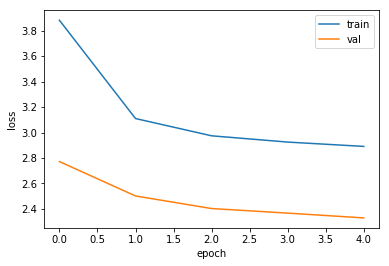

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

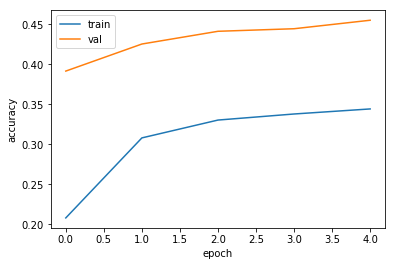

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

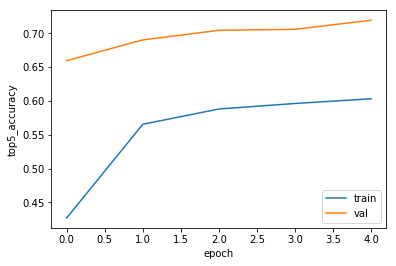

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model_step1.pytorch_state')